# Graphs Visualizing Election Turnout

In [1]:
# Some initialization magic
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import collections

# Let's load up the data
import json
import codecs
import gzip

with gzip.GzipFile("scrapyproject/results.json.gz") as fin:
    fin = codecs.getreader('utf-8')(fin)
    tables = [json.loads(line) for line in fin]

In [2]:
TIMES = ['10:00', '12:00', '15:00', '18:00']
                
def yield_turnout():
    turnout = [t for t in tables if t['data_type'] == 'turnout_uik']
    for table in turnout:
        for i, (header, row) in enumerate(zip(table['row_headers'], table['data'])):
            if i == 0:
                # skip total row
                continue
            yield {'region': table['region'], 'territory': table['territory'],
                   'polling_station': header, 'turnout': row, 'url': table['url']}

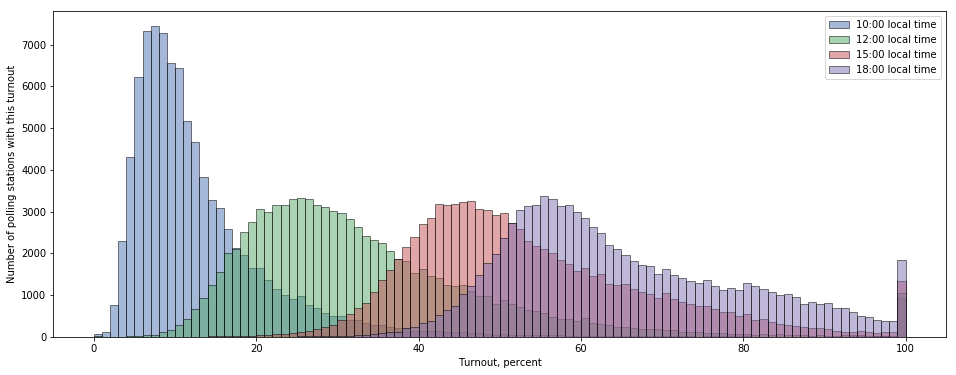

In [3]:
def calc_rounded_turnout(time):
    if time not in TIMES:
        raise ValueError
    time_idx = TIMES.index(time)
    rounded_percentages = [round(t['turnout'][time_idx], 0) for t in yield_turnout()]
    return rounded_percentages

plt.style.use('seaborn-deep')
plt.rcParams["patch.force_edgecolor"] = True
plt.figure(figsize=(16, 6))
plt.hist(calc_rounded_turnout('10:00'), 100, alpha=0.5, label='10:00 local time')
plt.hist(calc_rounded_turnout('12:00'), 100, alpha=0.5, label='12:00 local time')
plt.hist(calc_rounded_turnout('15:00'), 100, alpha=0.5, label='15:00 local time')
plt.hist(calc_rounded_turnout('18:00'), 100, alpha=0.5, label='18:00 local time')
plt.xlabel('Turnout, percent')
plt.ylabel('Number of polling stations with this turnout')
plt.legend()
print()

## Polling stations with 100% turnout

A suprising number of polling station reported 100% turnout, even at 10:00am.
What were they?

In [4]:
hundred_pct = sorted(['%(region)s / %(territory)s / %(polling_station)s' % t 
                      for t in yield_turnout() if t['turnout'][0] == 100])
len(hundred_pct)

924

In [5]:
hundred_pct[:10]

['Архангельская область / Архангельск, Южная / УИК №1000',
 'Архангельская область / Архангельск, Южная / УИК №1001',
 'Архангельская область / Архангельск, Южная / УИК №1002',
 'Архангельская область / Архангельск, Южная / УИК №1003',
 'Архангельская область / Архангельск, Южная / УИК №1004',
 'Архангельская область / Архангельск, Южная / УИК №1005',
 'Архангельская область / Архангельск, Южная / УИК №1006',
 'Архангельская область / Архангельск, Южная / УИК №1007',
 'Архангельская область / Архангельск, Южная / УИК №1008',
 'Архангельская область / Архангельск, Южная / УИК №1009']

In [6]:
#
# Let's have a look at how many people voted at these polling stations with 100% attendance
# 
ROW_HEADERS = [t for t in tables if t["data_type"] == "results_uik"][0]['row_headers']
            
turnout_dict = {}
for d in yield_turnout():
    key = (d['region'], d['territory'], d['polling_station'])
    turnout_dict[key] = d['turnout']


def yield_grouped():
    results = [t for t in tables if t['data_type'] == 'results_uik']
    for table in results:
        assert table['row_headers'] == ROW_HEADERS
        for column_number, column_name in enumerate(table['column_headers']):
            if column_number == 0:
                continue
            key = (table['region'], table['territory'], column_name)
            results = {dim: table['data'][row_number][column_number]
                       for (row_number, dim) in enumerate(ROW_HEADERS)}
            yield {
                'region': table['region'], 'territory': table['territory'],
                'polling_station': column_name, 'turnout': turnout_dict[key],
                'results': results, 'url': table['url']
            }
            
grouped = {'%(region)s / %(territory)s / %(polling_station)s' % d: d for d in yield_grouped()}

In [7]:
list(grouped.values())[2]

{'polling_station': 'УИК №873',
 'region': 'Республика Бурятия',
 'results': {'Бабурин Сергей Николаевич': 0.0,
  'Грудинин Павел Николаевич': 4.0,
  'Жириновский Владимир Вольфович': 2.0,
  'Путин Владимир Владимирович': 36.0,
  'Собчак Ксения Анатольевна': 0.0,
  'Сурайкин Максим Александрович': 0.0,
  'Титов Борис Юрьевич': 0.0,
  'Число бюллетеней в стационарных ящиках для голосования': 42.0,
  'Число действительных избирательных бюллетеней': 42.0,
  'Число избирателей, включенных в список избирателей': 42.0,
  'Число избирательных бюллетеней в переносных ящиках для голосования': 0.0,
  'Число избирательных бюллетеней, выданных в помещении для голосования в день голосования': 42.0,
  'Число избирательных бюллетеней, выданных вне помещения для голосования в день голосования': 0.0,
  'Число избирательных бюллетеней, выданных избирателям, проголосовавшим досрочно': 0.0,
  'Число избирательных бюллетеней, не учтенных при получении': 0.0,
  'Число избирательных бюллетеней, полученных уч

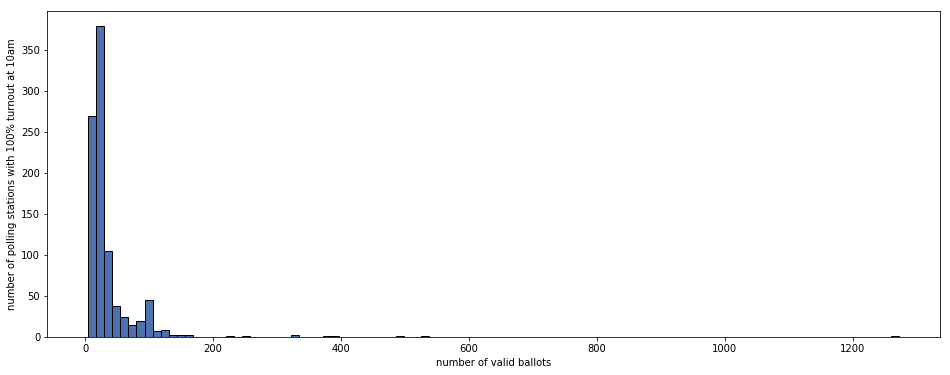

In [8]:
VALID_BALLOTS = 'Число действительных избирательных бюллетеней'
voters = [grouped[key]['results'][VALID_BALLOTS] for key in hundred_pct]
plt.figure(figsize=(16, 6))
plt.hist(voters, bins=100)
plt.xlabel('number of valid ballots')
plt.ylabel('number of polling stations with 100% turnout at 10am')
print()

In [9]:
collections.Counter(voters).most_common(10)

[(12.0, 46),
 (19.0, 44),
 (24.0, 40),
 (11.0, 38),
 (13.0, 38),
 (14.0, 36),
 (27.0, 34),
 (18.0, 33),
 (10.0, 32),
 (29.0, 30)]

In [10]:
early_bird = [st for st in list(grouped.values())
              if st['turnout'][0] == 100 and st['results'][VALID_BALLOTS] > 1000]
early_bird

[{'polling_station': 'УИК №1120',
  'region': 'Брянская область',
  'results': {'Бабурин Сергей Николаевич': 2.0,
   'Грудинин Павел Николаевич': 44.0,
   'Жириновский Владимир Вольфович': 35.0,
   'Путин Владимир Владимирович': 1178.0,
   'Собчак Ксения Анатольевна': 4.0,
   'Сурайкин Максим Александрович': 5.0,
   'Титов Борис Юрьевич': 1.0,
   'Число бюллетеней в стационарных ящиках для голосования': 1280.0,
   'Число действительных избирательных бюллетеней': 1273.0,
   'Число избирателей, включенных в список избирателей': 1280.0,
   'Число избирательных бюллетеней в переносных ящиках для голосования': 0.0,
   'Число избирательных бюллетеней, выданных в помещении для голосования в день голосования': 1280.0,
   'Число избирательных бюллетеней, выданных вне помещения для голосования в день голосования': 0.0,
   'Число избирательных бюллетеней, выданных избирателям, проголосовавшим досрочно': 0.0,
   'Число избирательных бюллетеней, не учтенных при получении': 0.0,
   'Число избиратель